# Project 4: Highway Traffic Prediction
***
## Due Date: 2023.01.31
***
The following Jupyter Notebook contains the machine learning project for predicting highway traffic on four junctions using Random Forest and SVM Regression models to predict the data for another coming year.
***
Dataset by: https://www.kaggle.com/code/jaymineshkumarpatel/traffic-prediction/data
***

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

***
Reading the dataset and save it into an dataframe, while keeping the datetimes as index column. Also removing the ID column from the dataset, cause the ID dont affect the machine learning models in any way.
***

In [16]:
df = pd.read_csv('traffic.csv', parse_dates=True, index_col='DateTime')
df.drop('ID', axis=1, inplace=True)
print(df)

                     Junction  Vehicles
DateTime                               
2015-11-01 00:00:00         1        15
2015-11-01 01:00:00         1        13
2015-11-01 02:00:00         1        10
2015-11-01 03:00:00         1         7
2015-11-01 04:00:00         1         9
...                       ...       ...
2017-06-30 19:00:00         4        11
2017-06-30 20:00:00         4        30
2017-06-30 21:00:00         4        16
2017-06-30 22:00:00         4        22
2017-06-30 23:00:00         4        12

[48120 rows x 2 columns]


In [17]:
df.describe()

,Junction,Vehicles
count,48120.000000,48120.000000
mean,2.180549,22.791334
std,0.966955,20.750063
min,1.000000,1.000000
25%,1.000000,9.000000
50%,2.000000,15.000000
75%,3.000000,29.000000
max,4.000000,180.000000


***
With the below defined function an time series plot for every junction can be plotted to see the trend of amount of vehicles passing a junction over the time the data has been measured.
***

In [18]:
def make_time_series():
    for junction in range(1, 5):
        f, ax = plt.subplots(figsize=(17, 5))
        data = df[df.Junction == junction]
        ax.plot(data.index, data['Vehicles'])
        ax.set_title('Plotting the time series for every junction')
        ax.grid(True, ls='-.', alpha=0.75)
        plt.show()

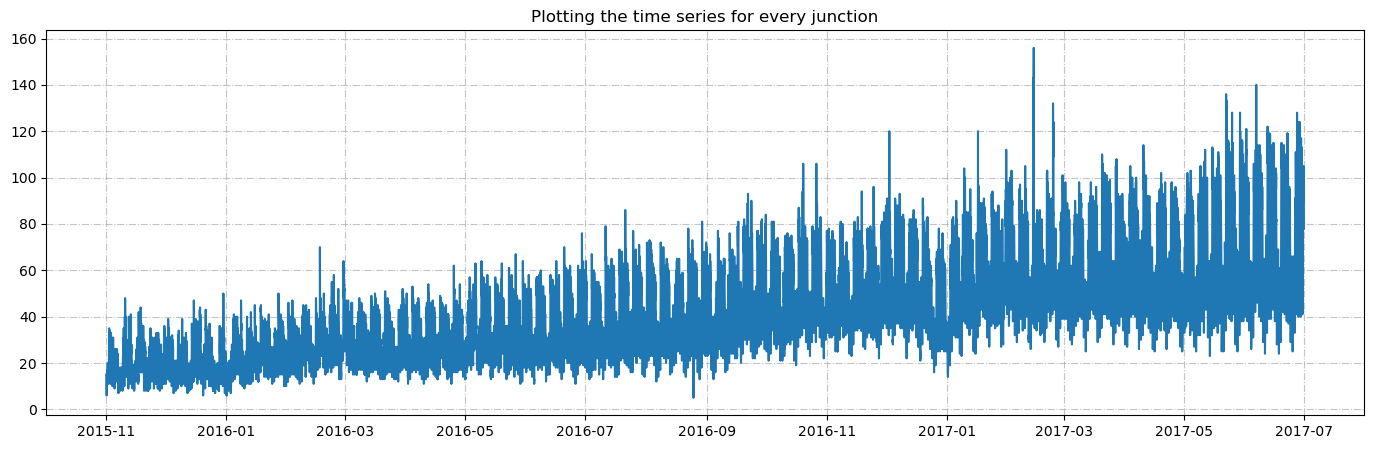

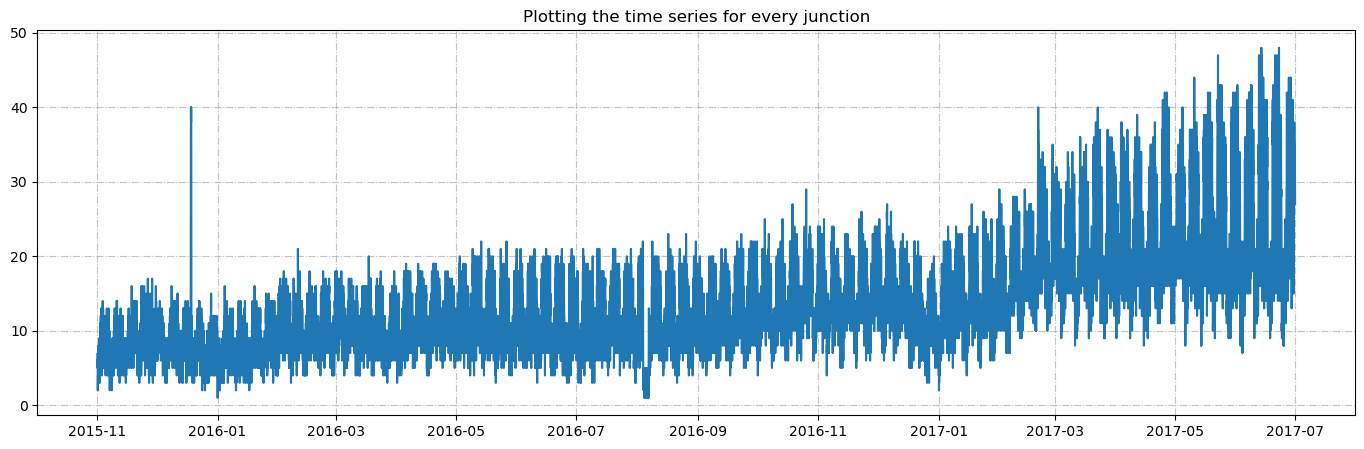

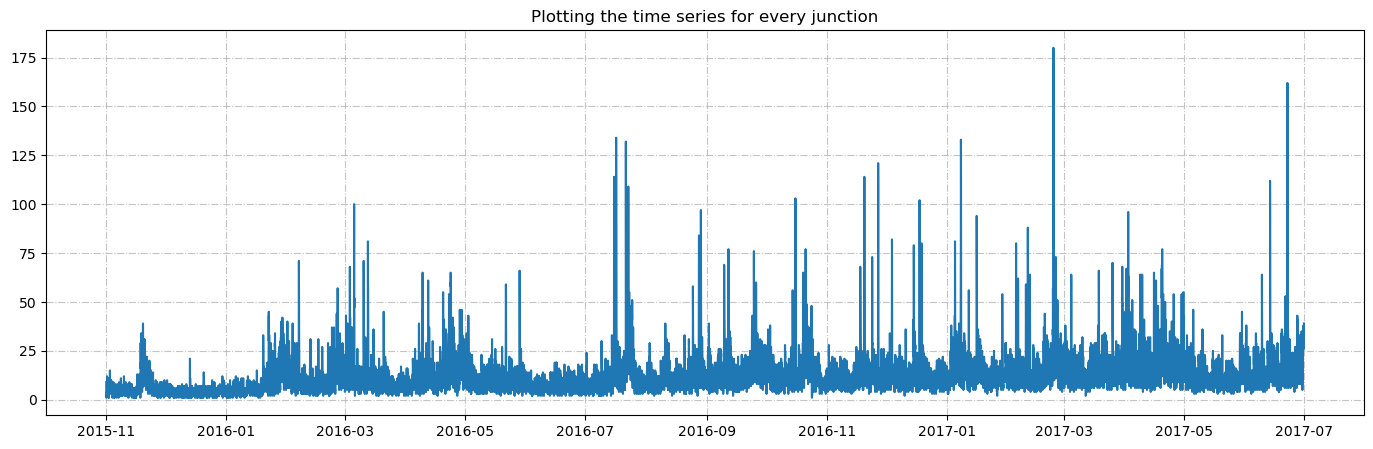

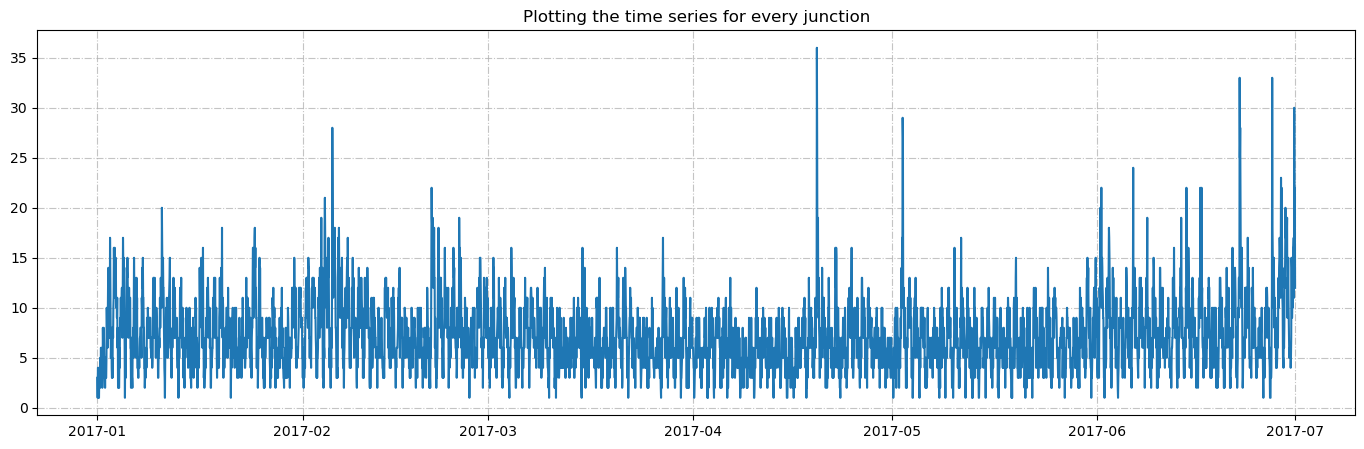

In [19]:
make_time_series()

To improve the learning rate of the models the data gets z-scaled with an StandardScaler. This is done because of the above shown time series, in which a wider distribution of the hourly measured vehicles is visible.

In [20]:
scaler = StandardScaler()
scaler.fit(df.Vehicles.values.reshape(-1, 1))
df['Vehicles'] = scaler.transform(df.Vehicles.values.reshape(-1, 1))
print(df)

                     Junction  Vehicles
DateTime                               
2015-11-01 00:00:00         1 -0.375489
2015-11-01 01:00:00         1 -0.471875
2015-11-01 02:00:00         1 -0.616454
2015-11-01 03:00:00         1 -0.761034
2015-11-01 04:00:00         1 -0.664648
...                       ...       ...
2017-06-30 19:00:00         4 -0.568261
2017-06-30 20:00:00         4  0.347408
2017-06-30 21:00:00         4 -0.327296
2017-06-30 22:00:00         4 -0.038137
2017-06-30 23:00:00         4 -0.520068

[48120 rows x 2 columns]


***
Now creating the prediction data for the coming year. The last measured data were on date:

In [21]:
print(df.index[-1])

2017-06-30 23:00:00


So the prediction data starts at 2017-07-01 00:00:00 and ends at 2018-06-30 23:00:00.

In [22]:
start_time = pd.Timestamp(2017, 7, 1, 0, 0, 0)
print(start_time)
end_time = pd.Timestamp(2018, 6, 30, 23, 0, 0)
print(end_time)

2017-07-01 00:00:00
2018-06-30 23:00:00


In [23]:
# creating a dataframe for the year to predict with same features as used to train the model
pred_data = pd.DataFrame()
pred_data.index = pd.date_range(start=start_time, end=end_time, freq='H')
pred_data['Year'] = pd.Series(pred_data.index).apply(lambda x: x.year).to_list()
pred_data['Month'] = pd.Series(pred_data.index).apply(lambda x: x.month).to_list()
pred_data['Day'] = pd.Series(pred_data.index).apply(lambda x: x.day).to_list()
pred_data['Hour'] = pd.Series(pred_data.index).apply(lambda x: x.hour).to_list()
print(pred_data)

                     Year  Month  Day  Hour
2017-07-01 00:00:00  2017      7    1     0
2017-07-01 01:00:00  2017      7    1     1
2017-07-01 02:00:00  2017      7    1     2
2017-07-01 03:00:00  2017      7    1     3
2017-07-01 04:00:00  2017      7    1     4
...                   ...    ...  ...   ...
2018-06-30 19:00:00  2018      6   30    19
2018-06-30 20:00:00  2018      6   30    20
2018-06-30 21:00:00  2018      6   30    21
2018-06-30 22:00:00  2018      6   30    22
2018-06-30 23:00:00  2018      6   30    23

[8760 rows x 4 columns]


***
Creating functions for calculating the huber loss and for training both the machine learning regression models

In [24]:
def huber_loss(y_test, prediction):
    # defining a huber loss function with delta 2
    delta = 2
    sum = 0
    for i in range(len(y_test)):
        if abs(y_test[i] - prediction[i]) <= delta:
            sum += 1 / 2 * (y_test[i] - prediction[i]) ** 2
        else:
            sum += delta * abs(y_test[i] - prediction[i]) - 1/2 * delta ** 2
    huber_loss = sum / len(y_test)
    return huber_loss

In [25]:
def predict_with_RFR(X_train, X_test, y_train, y_test):
    regr = RandomForestRegressor(random_state=0)
    regr.fit(X_train, y_train)
    prediction = regr.predict(X_test)
    # calculating mae, mse, rmse, huber loss and mape
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    rmse = mean_squared_error(y_test, prediction, squared=False)
    huber = huber_loss(y_test, prediction)
    mape = mean_absolute_percentage_error(y_test, prediction)
    # also returning the regressor for predicting the next year
    return mae, mse, rmse, huber, mape, regr

In [26]:
def predict_with_SVR(X_train, X_test, y_train, y_test):
    svr = SVR()
    svr.fit(X_train, y_train)
    prediction = svr.predict(X_test)
    # calculating mae, mse, rmse, huber loss and mape
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    rmse = mean_squared_error(y_test, prediction, squared=False)
    huber = huber_loss(y_test, prediction)
    mape = mean_absolute_percentage_error(y_test, prediction)
    return mae, mse, rmse, huber, mape

***
Now train both models and predict the coming vehicles for a whole year for every junction
***

In [27]:
# splitting DateTime into Year, Month, Day and Hour for more features to learn from
df['Year'] = pd.Series(df.index).apply(lambda x: x.year).to_list()
df['Month'] = pd.Series(df.index).apply(lambda x: x.month).to_list()
df['Day'] = pd.Series(df.index).apply(lambda x: x.day).to_list()
df['Hour'] = pd.Series(df.index).apply(lambda x: x.hour).to_list()

for junction in range(1, 5):
    juncData = df[df.Junction == junction]
    # separate the vehicles column from the very dataframe to use it as label
    vehicles = juncData['Vehicles']
    juncData.drop('Vehicles', axis=1, inplace=True)
    juncData.drop('Junction', axis=1, inplace=True)
    # split the data with an 70/30 training/test ratio
    print('* * * * * * * * * * * * * * * * * * * * * * * * *')
    print('Prediction for junction ', junction)
    X_train, X_test, y_train, y_test = train_test_split(juncData, vehicles, test_size=0.7)
    mae, mse, rmse, huber, mape, regr = predict_with_RFR(X_train, X_test, y_train, y_test)
    print('REGR metrics:')
    print('MAE: ', mae)
    print('MSE: ', mse)
    print('RMSE: ', rmse)
    print('Huber: ', huber)
    print('MAPE: ', mape)
    mae, mse, rmse, huber, mape = predict_with_SVR(X_train, X_test, y_train, y_test)
    print('SVR metrics:')
    print('MAE: ', mae)
    print('MSE: ', mse)
    print('RMSE: ', rmse)
    print('Huber: ', huber)
    print('MAPE: ', mape)
    # use the above defined pred_data data frame with the entries to predicting
    vehicles = regr.predict(pred_data)
    # inverse the scaling for the predicted data
    vehicles = scaler.inverse_transform(vehicles.reshape(-1, 1))
    pred_data['Predicted_Vehicles'] = vehicles
    print('Now the prediction for the next year with usage of RFR')
    print(pred_data)
    # write the predicted data to a .csv file
    pred_data.to_csv(f'next_year_prediction_junction_{junction}.csv', encoding='utf-8', index=False)
    # drop the predicted vehicles column for the next loop through
    pred_data.drop('Predicted_Vehicles', axis=1, inplace=True)

C:\Users\baerl\anaconda3\envs\machinelearning\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


* * * * * * * * * * * * * * * * * * * * * * * * *
Prediction for junction  1
REGR metrics:
MAE:  0.26215829526874623
MSE:  0.12852563267253317
RMSE:  0.3585047177828113
Huber:  0.06423994519972785
MAPE:  0.8812403570313588
SVR metrics:
MAE:  0.8693553446331079
MSE:  1.2627788105750228
RMSE:  1.1237343149406014
Huber:  0.6048469436863424
MAPE:  3.3443419047146614
Now the prediction for the next year with usage of RFR
                     Year  Month  Day  Hour  Predicted_Vehicles
2017-07-01 00:00:00  2017      7    1     0               80.64
2017-07-01 01:00:00  2017      7    1     1               70.25
2017-07-01 02:00:00  2017      7    1     2               43.43
2017-07-01 03:00:00  2017      7    1     3               44.75
2017-07-01 04:00:00  2017      7    1     4               30.28
...                   ...    ...  ...   ...                 ...
2018-06-30 19:00:00  2018      6   30    19              101.26
2018-06-30 20:00:00  2018      6   30    20              101.38
2018

C:\Users\baerl\anaconda3\envs\machinelearning\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


REGR metrics:
MAE:  0.12756218168031366
MSE:  0.028830223029999553
RMSE:  0.16979464959179236
Huber:  0.014415111514999765
MAPE:  0.6382530999540139
SVR metrics:
MAE:  0.25745201744277124
MSE:  0.1277169908005016
RMSE:  0.3573751401545743
Huber:  0.06385849540025079
MAPE:  1.57092811962911
Now the prediction for the next year with usage of RFR
                     Year  Month  Day  Hour  Predicted_Vehicles
2017-07-01 00:00:00  2017      7    1     0               21.66
2017-07-01 01:00:00  2017      7    1     1               26.68
2017-07-01 02:00:00  2017      7    1     2               24.57
2017-07-01 03:00:00  2017      7    1     3               19.61
2017-07-01 04:00:00  2017      7    1     4               14.71
...                   ...    ...  ...   ...                 ...
2018-06-30 19:00:00  2018      6   30    19               39.35
2018-06-30 20:00:00  2018      6   30    20               36.46
2018-06-30 21:00:00  2018      6   30    21               35.42
2018-06-30 22:

C:\Users\baerl\anaconda3\envs\machinelearning\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


REGR metrics:
MAE:  0.17726177403600013
MSE:  0.10528014365256959
RMSE:  0.32446901801646577
Huber:  0.0501804988193692
MAPE:  0.8970580529923474
SVR metrics:
MAE:  0.31352024011507024
MSE:  0.24080374730039175
RMSE:  0.49071758405460847
Huber:  0.11181463318856373
MAPE:  2.03621841271266
Now the prediction for the next year with usage of RFR
                     Year  Month  Day  Hour  Predicted_Vehicles
2017-07-01 00:00:00  2017      7    1     0               13.38
2017-07-01 01:00:00  2017      7    1     1               12.67
2017-07-01 02:00:00  2017      7    1     2                9.60
2017-07-01 03:00:00  2017      7    1     3                7.00
2017-07-01 04:00:00  2017      7    1     4                7.31
...                   ...    ...  ...   ...                 ...
2018-06-30 19:00:00  2018      6   30    19               27.11
2018-06-30 20:00:00  2018      6   30    20               24.95
2018-06-30 21:00:00  2018      6   30    21               24.13
2018-06-30 22:0

C:\Users\baerl\anaconda3\envs\machinelearning\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


REGR metrics:
MAE:  0.09591018569902618
MSE:  0.01617945643231306
RMSE:  0.12719849225644564
Huber:  0.008089728216156552
MAPE:  0.1674833519374521
SVR metrics:
MAE:  0.12223235852940799
MSE:  0.026015797271378496
RMSE:  0.16129413278659113
Huber:  0.013007898635689243
MAPE:  0.23147414678732864
Now the prediction for the next year with usage of RFR
                     Year  Month  Day  Hour  Predicted_Vehicles
2017-07-01 00:00:00  2017      7    1     0                7.33
2017-07-01 01:00:00  2017      7    1     1                7.09
2017-07-01 02:00:00  2017      7    1     2                3.98
2017-07-01 03:00:00  2017      7    1     3                3.86
2017-07-01 04:00:00  2017      7    1     4                2.64
...                   ...    ...  ...   ...                 ...
2018-06-30 19:00:00  2018      6   30    19               11.63
2018-06-30 20:00:00  2018      6   30    20               14.49
2018-06-30 21:00:00  2018      6   30    21               14.27
2018-06-